<h2><font color="#004D7F" size=5>Módulo 1: Modelos múltiples</font></h2>



<h1><font color="#004D7F" size=6> 5. Seleccion dinamica de conjuntos </font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Aprendizaje Automático II</font><br>
<font color="#004D7F" size=3>Universidad Nacional de Educación a Distancia</font>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Selección dinámica de conjuntos](#section1)
   * [1.1. Librería DESlib](#section11)
   * [1.2. Dataset](#section12)
* [2. Evaluación de modelos KNORA](#section2)
    * [2.1. KNORA-Eliminate (KNORA-E)](#section21)
    * [2.2. KNORA-Union (KNORA-U)](#section22)
* [3. Ajuste de hiperparámetros para KNORA](#section3)
    * [3.1. Parámetro `k` en KNN](#section31)
    * [3.2. Explorar algoritmos para el grupo de clasificadores](#section32)
* [Ejercicios](#sectionEj)

---

<a id="section0"></a>
# <font color="#004D7F">0. Contexto</font>

- Es una técnica de aprendizaje de conjuntos que selecciona automáticamente un subconjunto de miembros del conjunto justo a tiempo al realizar una predicción. 
- Implica ajustar múltiples modelos en train y luego seleccionar los modelos que se espera que funcionen mejor al hacer una predicción.
- Se suele usar un modelo KNN para ubicar ejemplos que estén más cerca del nuevo ejemplo que se va a predecir, evaluando todos en el vecindario y usando los modelos que funcionan mejor en el vecindario para hacer una predicción para el nuevo ejemplo. 

En este tutorial veremos:
- Cómo son los algoritmos de selección dinámica.
- Cómo desarrollar y evaluar la selección de conjuntos usando Scikit-learn.
- Cómo explorar los hiperparámetros de selección dinámica de conjuntos.

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Selección dinámica de conjuntos</font>

### Selección de clasificador dinámico Vs. Selección dinámica de conjuntos

- __Selección de clasificador dinámico (DCS)__: algoritmos que eligen dinámicamente __uno entre muchos__ modelos entrenados para hacer una predicción basada en los detalles específicos de la entrada.
- __Selección dinámica de conjuntos (DES)__: algoritmos que eligen dinámicamente __un subconjunto__ de modelos entrenados para hacer una predicción basada en los detalles específicos de la entrada.

Los algoritmos DES funcionan de manera muy similar a los algoritmos DCS, excepto que __las predicciones se realizan utilizando votos de múltiples modelos clasificadores__ en lugar de un único mejor modelo. De hecho, cada región del espacio de características de entrada pertenece a un subconjunto de modelos que funcionan mejor en esa región.


### KNORA
___k_-Nearest Neighbor Oracle (KNORA)__ es el enfoque más común, es una extensión natural del algoritmo de _Dynamic Classifier Selection Local Accuracy (DCS-LA)_. 
- DCS-LA implica seleccionar los _k_ vecinos más cercanos de train para un nuevo patrón de entrada determinado, luego seleccionar el mejor clasificador en función de su desempeño en esa vecindad de _k_ ejemplos para hacer una predicción sobre el nuevo ejemplo.
- KNORA selecciona múltiples modelos que funcionan bien en la vecindad y cuyas predicciones luego se combinan mediante votación mayoritaria para hacer una predicción de resultado final.

Los modelos de clasificador seleccionados se denominan ___oráculos___ (_oracles_). 

### Versiones KNORA

Se describen dos versiones de KNORA:
- __KNORA-Eliminate (KNORA-E)__: Conjunto de clasificadores que consigue un accuracy perfecto en la vecindad del nuevo ejemplo, reduciendo el tamaño de la vecindad hasta localizar al menos un clasificador perfecto.
- __KNORA-Union (KNORA-U)__: Conjunto de todos los clasificadores que realizan al menos una predicción correcta sobre la vecindad con votación ponderada y votos proporcionales al accuracy de la vecindad.

### KNORA-E
- Implica seleccionar todos los clasificadores que logren predicciones perfectas sobre la vecindad de _k_ ejemplos en la vecindad. 
- Si ningún clasificador logra un accuracy del 100%, el tamaño del vecindario se reduce en uno y los modelos se reevalúan. 
- Este proceso se repite hasta que se descubre uno o más modelos que tienen un rendimiento perfecto y luego se utilizan para hacer una predicción para el nuevo ejemplo.


### KNORA-U
- Implica seleccionar todos los clasificadores que hagan al menos una predicción correcta en el vecindario. 
- Luego, las predicciones de cada clasificador se combinan utilizando un promedio ponderado, donde el número de predicciones correctas en el vecindario indica el número de votos asignados a cada clasificador.

<a id="section11"></a>
## <font color="#004D7F"> 1.1. Librería DESlib</font>

Para este ejercicio usaremos también DESlib.

In [1]:
#!pip install deslib

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la librería [DESlib](https://deslib.readthedocs.io/en/latest/).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la librería [DESlib](https://deslib.readthedocs.io/en/latest/).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre el Github [DESlib](https://github.com/scikit-learn-contrib/DESlib).
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información en PyPI sobre [DESlib](https://pypi.org/project/DESlib/0.1/).
</div>

DESlib proporciona una implementación del algoritmo KNORA a través de las clases `KNORAE` y `KNORAU`. 
- Ambas clases utilizan un algoritmo KNN para seleccionar el vecino con un valor predeterminado de `k = 7`. 
- Se utiliza un conjunto Bagging como conjunto de modelos de clasificador de forma predeterminada.

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Dataset</font>

Podemos usar la función `make_classification()` para crear un problema de clasificación binaria sintética con 10,000 ejemplos y 20 características de entrada.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
print(X.shape, y.shape)

(10000, 20) (10000,)


La ejecución del ejemplo crea el conjunto de datos y resume la forma de la entrada y la salida de elementos del conjunto de datos para modelar, confirmando la configuración elegida.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: La libreía no ha sido actualizada a la última versión de Numpy, es por eso que le salen muchos errores tipo warning. Por tanto, tenga en cuenta que le van a salir muchos fallos, no se preocupue, ejecute primero con la versión que tenga y verifique que (aunque se salgan muchos errores tipo warning) obtenga un resultado.  Sin le sale un resultado con `nan` entonces tiene que realizar una instalación a una versión posterior. También le aparecerán varios errores tipo warning seguramente, omítalos y verifique que le salga un accuracy casi al final.
</div>

In [3]:
!pip install "numpy==1.23.5"

ERROR: Ignored the following versions that require a different python version: 1.22.0 Requires-Python >=3.8; 1.22.1 Requires-Python >=3.8; 1.22.2 Requires-Python >=3.8; 1.22.3 Requires-Python >=3.8; 1.22.4 Requires-Python >=3.8; 1.23.0 Requires-Python >=3.8; 1.23.1 Requires-Python >=3.8; 1.23.2 Requires-Python >=3.8; 1.23.3 Requires-Python >=3.8; 1.23.4 Requires-Python >=3.8; 1.23.5 Requires-Python >=3.8; 1.24.0 Requires-Python >=3.8; 1.24.1 Requires-Python >=3.8; 1.24.2 Requires-Python >=3.8; 1.24.3 Requires-Python >=3.8; 1.24.4 Requires-Python >=3.8; 1.25.0 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.1 Requires-Python <3.13,>=3.9; 1.26.2 Requires-Python >=3.9; 1.26.3 Requires-Python >=3.9; 1.26.4 Requires-Python >=3.9; 2.0.0 Requires-Python >=3.9; 2.0.1 Requires-Python >=3.9; 2.0.2 Requires-Python >=3.9; 2.1.0 Requires-Python >=3.10; 2.1.0rc1 Requires-Python >=3.10; 2.1.1 Requires-Python >=3.10; 2.1.2 Req

In [4]:
import numpy
print(numpy.__version__)

1.19.1


---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a> 
# <font color="#004D7F"> 2. Evaluación de modelos KNORA </font>

Ahora que estamos familiarizados con la API DESlib, veamos cómo utilizar cada algoritmo KNORA-E y KNORA-U.

<a id="section21"></a> 
## <font color="#004D7F"> 2.1. KNORA-Eliminate (KNORA-E)</font>

Podemos evaluar un modelo KNORA-E en el conjunto de datos sintéticos. 

<a id="section211"></a> 
### <font color="#004D7F"> 2.1.1. Evaluación</font>

Veamos la evaluación:
- En este caso, usaremos hiperparámetros del modelo predeterminado, con Bagging y `k = 7` para la selección de la vecindad local. 
- Utilizamos una validación cruzada estratificada repetida de _k_ veces con 3 repeticiones y 10 pliegues. 

In [8]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.des.knora_e import KNORAE

# definir el modelo
model = KNORAE()
# Validación cruzada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluación
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.915 (0.009)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section22"></a> 
## <font color="#004D7F"> 2. KNORA-Union (KNORA-U)</font>

Podemos evaluar un modelo KNORA-U en el conjunto de datos sintéticos.

<a id="section221"></a> 
### <font color="#004D7F"> 2.2.1. Evaluación</font>

Veamos la evaluación:
- En este caso, usaremos hiperparámetros del modelo predeterminado, incluidos bagging como conjunto de modelos clasificadores y `k = 7` para la selección de la vecindad local al hacer una predicción. 
- Evaluaremos el modelo utilizando una validación cruzada estratificada repetida de _k_ veces con 3 repeticiones y 10 pliegues. 

In [9]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.des.knora_u import KNORAU

# definir el modelo
model = KNORAU()
# Validación cruzada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluación
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.935 (0.008)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a> 
# <font color="#004D7F"> 3. Ajuste de hiperparámetros para KNORA</font>

Hay muchos hiperparámetros que podemos observar para KNORA, aunque en este caso, veremos el valor de `k` en el modelo KNN utilizado en la evaluación local de los modelos, y cómo usar un hiperparámetro personalizados para el conjunto de clasificadores. 

Usaremos KNORA-U como base para estos experimentos.

<a id="section31"></a> 
## <font color="#004D7F"> 3.1. Parámetro `k` en KNN</font>

La configuración del algoritmo de KNN es fundamental ya que define la vecindad en la que se considera cada clasificador. El valor `k` controla el tamaño de la vecindad:
- Valores demasiado pequeños significará que los ejemplos relevantes en el conjunto de entrenamiento podrían excluirse de la vecindad.
- Valores demasiado grandes pueden significar que la señal está siendo eliminada por demasiados ejemplos. 

Veamos con valores `k` de 2 a 21.

In [10]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.des.knora_u import KNORAU
from matplotlib import pyplot

def get_dataset():
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y

In [11]:
# Lista de modelos
def get_models():
    models = dict()
    # exploramos valores de k de 2 a 21
    for n in range(2, 22):
        models[str(n)] = KNORAU(k=n)
    return models

In [12]:
# evaluación de cada modelo
def evaluate_model(model, X, y):
    # Validación cruzada
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Evaluación
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [13]:
# definir el dataset
X, y = get_dataset()
# obtener los modelos
models = get_models()
# evaluación y almacenamiento de resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>2 0.934 (0.008)
>3 0.933 (0.007)
>4 0.935 (0.009)
>5 0.933 (0.010)
>6 0.937 (0.008)
>7 0.935 (0.007)
>8 0.937 (0.011)
>9 0.935 (0.009)
>10 0.937 (0.009)
>11 0.936 (0.006)
>12 0.933 (0.009)
>13 0.935 (0.009)
>14 0.936 (0.009)
>15 0.936 (0.010)
>16 0.935 (0.007)
>17 0.935 (0.008)
>18 0.934 (0.010)
>19 0.936 (0.009)
>20 0.939 (0.007)
>21 0.933 (0.007)


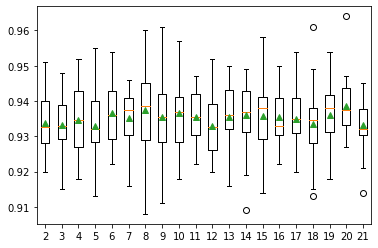

In [14]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section32"></a> 
## <font color="#004D7F"> 3.2. Explorar algoritmos para el grupo de clasificadores</font>

Como hemos visto de forma predeterminada utiliza Bagging.

<a id="section321"></a> 
### <font color="#004D7F"> 3.2.1. Grupo de clasificadores</font>

Se puede considerar un grupo personalizado de clasificadores. Esto requiere:
1. Primero definir una lista de modelos de clasificador para usar y ajustar cada uno en el conjunto de datos de entrenamiento. 
    - Desafortunadamente, esto significa que los métodos automáticos de evaluación del modelo de validación cruzada k-fold en scikit-learn no se pueden utilizar en este caso. 
2. En su lugar, utilizaremos una división de prueba de entrenamiento para poder ajustar el grupo de clasificadores manualmente en el conjunto de datos de entrenamiento.
    - La lista de clasificadores aptos se puede especificar para la clase KNORA-U (o KNORA-E) a través del argumento `pool_classifiers`. En este caso, utilizaremos un grupo que incluye regresión logística, un árbol de decisión y Naive Bayes. 

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from deslib.des.knora_u import KNORAU
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

X, y = get_dataset()
# división en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# pool de clasificadores
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]
# entrenamos en train cada clasificador
for c in classifiers:
    c.fit(X_train, y_train)
# definimos el modelo KNORA-U con los clasificadores entrenados
model = KNORAU(pool_classifiers=classifiers)
# Entrenamos KNORA
model.fit(X_train, y_train)
# Hacer prediciones en test y evaluar
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

Accuracy: 0.914


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section322"></a> 
### <font color="#004D7F"> 3.2.2. Modelo contribuyente</font>

Para adoptar el modelo KNORA, debe funcionar mejor que cualquier modelo contribuyente. De lo contrario, simplemente utilizaríamos el modelo contribuyente que funcione mejor. Podemos verificar esto evaluando el desempeño de cada clasificador contribuyente en test.

In [17]:
# evaluate contributing models
print('Total accuracy: %.3f' % (score))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

Total accuracy: 0.873
>LogisticRegression: 0.878
>DecisionTreeClassifier: 0.881
>GaussianNB: 0.873


La ejecución del ejemplo primero informa el accuracy medio del modelo con el grupo personalizado de clasificadores y el accuracy de cada modelo contribuyente.

En este caso, podemos ver que nuevamente, el KNORA-U logra un accuracy de alrededor del 91,3%, que es mejor que cualquier modelo contribuyente.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section323"></a> 
### <font color="#004D7F"> 3.2.3. Modelo contribuyente único</font>

En lugar de especificar un conjunto de clasificadores, también es posible especificar un algoritmo de conjunto único de la biblioteca scikit-learn y el algoritmo KNORA utilizará automáticamente los miembros internos del conjunto como clasificadores. 

Por ejemplo, podemos utilizar Random Forest con 1000 miembros como clasificador base

In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from deslib.des.knora_u import KNORAU
from sklearn.ensemble import RandomForestClassifier

X, y = get_dataset()
# division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# definimos el pool
pool = RandomForestClassifier(n_estimators=1000)
# entrenamos en trainfit the classifiers on the training set
pool.fit(X_train, y_train)
# definimos KNORAU
model = KNORAU(pool_classifiers=pool)
# entrenamos en train
model.fit(X_train, y_train)
# evaluamos
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

Accuracy: 0.968


In [20]:
# evaluamos el modelo solo
pred = pool.predict(X_test)
score = accuracy_score(y_test, pred)
print('>%s: %.3f' % (pool.__class__.__name__, score))

>RandomForestClassifier: 0.966


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="sectionEj"></a>
<h3><font color="#004D7F" size=6> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicios</font></h3>

Se proponen las siguientes actividades para consolidar el aprendizaje.

# <font color="#004D7F" size=5>Ejercicio 1</font>
__KNORA-E__. En los ejemplos finales hemos visto para KNORA-U, utilice el ejemplo con KNORA-E.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from deslib.des.knora_e import KNORAE
from sklearn.ensemble import RandomForestClassifier

X, y = get_dataset()
# division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# definimos el pool
pool = RandomForestClassifier(n_estimators=1000)
# entrenamos en trainfit the classifiers on the training set
pool.fit(X_train, y_train)
# definimos KNORAE
model = KNORAE(pool_classifiers=pool)
# entrenamos en train
model.fit(X_train, y_train)
# evaluamos
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)
print('Accuracy: %.3f' % (score))

# evaluamos el modelo solo
pred = pool.predict(X_test)
score = accuracy_score(y_test, pred)
print('>%s: %.3f' % (pool.__class__.__name__, score))

Accuracy: 0.971
>RandomForestClassifier: 0.967


# <font color="#004D7F" size=5>Ejercicio 2</font>
__Hiperparámetros__. ¿Qué otros hiperparámetros se pueden utilizar? Indaga y descubra más hiperparámetros y evalúe su uso.

# Hiperparámetros de KNORAU y KNORAE

## KNORAU (k-Nearest Oracles Union)

1. **`pool_classifiers`**: Lista de clasificadores (por defecto = `None`). El conjunto de clasificadores entrenados para el problema de clasificación correspondiente.
2. **`k`**: Número de vecinos utilizados para estimar la competencia de los clasificadores base (por defecto = `7`).
3. **`DFP`**: Booleano que determina si se aplica la poda dinámica de frienemy (por defecto = `False`).
4. **`with_IH`**: Booleano que indica si se utiliza el nivel de dureza de la región de competencia para decidir entre usar el algoritmo DS o el KNN (por defecto = `False`).
5. **`safe_k`**: Tamaño de la región de indecisión (por defecto = `None`).
6. **`IH_rate`**: Umbral de dureza. Si el nivel de dureza de la región de competencia es menor que `IH_rate`, se utiliza el clasificador KNN. De lo contrario, se utiliza el algoritmo DS (por defecto = `0.3`).
7. **`random_state`**: Controla la aleatoriedad del clasificador (por defecto = `None`).
8. **`knn_classifier`**: Algoritmo utilizado para estimar la región de competencia (`'knn'`, `'faiss'`, `None`; por defecto = `'knn'`).
9. **`knn_metric`**: Métrica utilizada por el clasificador k-NN para estimar distancias (`'minkowski'`, `'cosine'`, `'mahalanobis'`; por defecto = `'minkowski'`).
10. **`knne`**: Booleano que indica si se utiliza la igualdad de k-vecinos más cercanos (KNNE) para la estimación de la región de competencia (por defecto = `False`).
11. **`DSEL_perc`**: Porcentaje de los datos de entrada utilizados para ajustar DSEL (por defecto = `0.5`).
12. **`voting`**: Método de votación (`'hard'`, `'soft'`; por defecto = `'hard'`).

## KNORAE (k-Nearest Oracles Eliminate)

1. **`pool_classifiers`**: Lista de clasificadores (por defecto = `None`). El conjunto de clasificadores entrenados para el problema de clasificación correspondiente.
2. **`k`**: Número de vecinos utilizados para estimar la competencia de los clasificadores base (por defecto = `7`).
3. **`DFP`**: Booleano que determina si se aplica la poda dinámica de frienemy (por defecto = `False`).
4. **`with_IH`**: Booleano que indica si se utiliza el nivel de dureza de la región de competencia para decidir entre usar el algoritmo DS o el KNN (por defecto = `False`).
5. **`safe_k`**: Tamaño de la región de indecisión (por defecto = `None`).
6. **`IH_rate`**: Umbral de dureza. Si el nivel de dureza de la región de competencia es menor que `IH_rate`, se utiliza el clasificador KNN. De lo contrario, se utiliza el algoritmo DS (por defecto = `0.3`).
7. **`random_state`**: Controla la aleatoriedad del clasificador (por defecto = `None`).
8. **`knn_classifier`**: Algoritmo utilizado para estimar la región de competencia (`'knn'`, `'faiss'`, `None`; por defecto = `'knn'`).
9. **`knn_metric`**: Métrica utilizada por el clasificador k-NN para estimar distancias (`'minkowski'`, `'cosine'`, `'mahalanobis'`; por defecto = `'minkowski'`).
10. **`knne`**: Booleano que indica si se utiliza la igualdad de k-vecinos más cercanos (KNNE) para la estimación de la región de competencia (por defecto = `False`).
11. **`DSEL_perc`**: Porcentaje de los datos de entrada utilizados para ajustar DSEL (por defecto = `0.5`).
12. **`voting`**: Método de votación (`'hard'`, `'soft'`; por defecto = `'hard'`).

# <font color="#004D7F" size=5>Ejercicio 3</font>
__Más conjuntos de datos__. Busque un dataset original y verdadero (que no sea sintético) y evalúe el uso de los conceptos vistos en esta unidad. Los conjuntos de datos en pueden ser obtenidos del [repositorio de aprendizaje automático de UCI](https://archive.ics.uci.edu/).

In [22]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from deslib.dcs.ola import OLA
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from sklearn.metrics import accuracy_score

# Cargar el dataset
data = load_wine()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir nuevos clasificadores
classifiers = [SVC(), RandomForestClassifier(), KNeighborsClassifier()]

# Entrenar cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)

# Aplicar KNORAU
knorau = KNORAU(pool_classifiers=classifiers)
knorau.fit(X_train, y_train)
pred_knorau = knorau.predict(X_test)
score_knorau = accuracy_score(y_test, pred_knorau)
print('KNORAU Accuracy: %.3f' % (score_knorau))

# Aplicar KNORAE
knorae = KNORAE(pool_classifiers=classifiers)
knorae.fit(X_train, y_train)
pred_knorae = knorae.predict(X_test)
score_knorae = accuracy_score(y_test, pred_knorae)
print('KNORAE Accuracy: %.3f' % (score_knorae))

# Evaluar los modelos contribuyentes
print('Accuracy total KNORAU: %.3f' % (score_knorau))
print('Accuracy total KNORAE: %.3f' % (score_knorae))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

KNORAU Accuracy: 1.000
KNORAE Accuracy: 1.000
Accuracy total KNORAU: 1.000
Accuracy total KNORAE: 1.000
>SVC: 0.983
>RandomForestClassifier: 1.000
>KNeighborsClassifier: 0.966


# <font color="#004D7F" size=5>Ejercicio 4</font>
__Clasificadores__. Evalué todo los ejercicios anteriores con el uso de clasificadores distintos a los vistos en la unidad, i.e., diferentes a LoR, CART y NB.

In [23]:
# Cargar el dataset
data = load_wine()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir nuevos clasificadores
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]

# Entrenar cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)

# Aplicar KNORAU
knorau = KNORAU(pool_classifiers=classifiers)
knorau.fit(X_train, y_train)
pred_knorau = knorau.predict(X_test)
score_knorau = accuracy_score(y_test, pred_knorau)
print('KNORAU Accuracy: %.3f' % (score_knorau))

# Aplicar KNORAE
knorae = KNORAE(pool_classifiers=classifiers)
knorae.fit(X_train, y_train)
pred_knorae = knorae.predict(X_test)
score_knorae = accuracy_score(y_test, pred_knorae)
print('KNORAE Accuracy: %.3f' % (score_knorae))

# Evaluar los modelos contribuyentes
print('Accuracy total KNORAU: %.3f' % (score_knorau))
print('Accuracy total KNORAE: %.3f' % (score_knorae))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

KNORAU Accuracy: 1.000
KNORAE Accuracy: 1.000
Accuracy total KNORAU: 1.000
Accuracy total KNORAE: 1.000
>LogisticRegression: 0.983
>DecisionTreeClassifier: 0.966
>GaussianNB: 1.000


# <font color="#004D7F" size=5>Ejercicio 5</font>
__Modelo contribuyente único__. Evalué otro modelo contribuyente único analizando todo lo relacionado a este.

In [24]:
# Cargar el dataset
data = load_wine()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir nuevos clasificadores
classifiers = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]

# Entrenar cada clasificador en train
for c in classifiers:
    c.fit(X_train, y_train)

# Aplicar KNORAU
knorau = KNORAU(pool_classifiers=classifiers)
knorau.fit(X_train, y_train)
pred_knorau = knorau.predict(X_test)
score_knorau = accuracy_score(y_test, pred_knorau)
print('KNORAU Accuracy: %.3f' % (score_knorau))

# Aplicar KNORAE
knorae = KNORAE(pool_classifiers=classifiers)
knorae.fit(X_train, y_train)
pred_knorae = knorae.predict(X_test)
score_knorae = accuracy_score(y_test, pred_knorae)
print('KNORAE Accuracy: %.3f' % (score_knorae))

# Evaluar los modelos contribuyentes
print('Accuracy total KNORAU: %.3f' % (score_knorau))
print('Accuracy total KNORAE: %.3f' % (score_knorae))
for c in classifiers:
    pred = c.predict(X_test)
    score = accuracy_score(y_test, pred)
    print('>%s: %.3f' % (c.__class__.__name__, score))

KNORAU Accuracy: 1.000
KNORAE Accuracy: 1.000
Accuracy total KNORAU: 1.000
Accuracy total KNORAE: 1.000
>LogisticRegression: 0.983
>DecisionTreeClassifier: 0.949
>GaussianNB: 1.000


# <font color="#004D7F" size=5>Ejercicio 6</font>
__Más técnicas de DESlib__. DESlib es una librería que tiene muchas otras técnicas muy interesantes. Escoja 3 técnicas adicionales y desarróllas a imagen y semejanza de este cuaderno. También la parte teórica de los modelos que hayas seleccionado

# Técnicas de DESlib

La biblioteca **DESlib** (Dynamic Ensemble Selection Library) ofrece una variedad de técnicas avanzadas para la selección dinámica de clasificadores y conjuntos. Aquí tienes un resumen de las principales técnicas que permite:

## Técnicas de Selección Dinámica de Clasificadores (DCS)

1. **OLA (Overall Local Accuracy)**: Selecciona el clasificador con la mayor precisión local en la región de competencia.
2. **A Priori**: Selecciona el clasificador basado en la precisión a priori en la región de competencia.
3. **MCB (Multiple Classifier Behavior)**: Selecciona el clasificador basado en el comportamiento múltiple de los clasificadores en la región de competencia.

## Técnicas de Selección Dinámica de Conjuntos (DES)

1. **KNORA-Union (K-Nearest Oracles Union)**: Selecciona un conjunto de clasificadores que han clasificado correctamente al menos una muestra en la región de competencia.
2. **KNORA-Eliminate (K-Nearest Oracles Eliminate)**: Selecciona un conjunto de clasificadores que han clasificado correctamente todas las muestras en la región de competencia.
3. **DES-P (Dynamic Ensemble Selection Performance)**: Selecciona un conjunto de clasificadores basado en su rendimiento en la región de competencia.
4. **META-DES**: Utiliza un meta-clasificador para seleccionar el mejor conjunto de clasificadores basado en características dinámicas.

## Ejemplo de Uso

Aquí tienes un ejemplo de cómo utilizar la técnica KNORA-Eliminate con un conjunto de clasificadores de RandomForest:

```python
from sklearn.ensemble import RandomForestClassifier
from deslib.des.knora_e import KNORAE
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entrenar un conjunto de clasificadores
pool_classifiers = RandomForestClassifier(n_estimators=10)
pool_classifiers.fit(X_train, y_train)

# Inicializar el modelo DES
knorae = KNORAE(pool_classifiers)

# Preprocesar el conjunto de datos de selección dinámica (DSEL)
X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
knorae.fit(X_dsel, y_dsel)

# Predecir nuevas muestras
y_pred = knorae.predict(X_test)

---

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>